----- k_path report begin ----------
real-space lattice vectors
 [[1.      0.     ]
 [0.5     0.86603]]
k-space metric tensor
 [[ 1.33333 -0.66667]
 [-0.66667  1.33333]]
internal coordinates of nodes
 [[0.      0.     ]
 [0.66667 0.33333]
 [0.5     0.5    ]
 [0.      0.     ]]
reciprocal-space lattice vectors
 [[ 1.      -0.57735]
 [ 0.       1.1547 ]]
cartesian coordinates of nodes
 [[0.00000e+00 0.00000e+00]
 [6.66667e-01 1.56412e-17]
 [5.00000e-01 2.88675e-01]
 [0.00000e+00 0.00000e+00]]
list of segments:
  length = 0.66667  from  [0. 0.]  to  [0.66667 0.33333]
  length = 0.33333  from  [0.66667 0.33333]  to  [0.5 0.5]
  length = 0.57735  from  [0.5 0.5]  to  [0. 0.]
node distance list: [0.      0.66667 1.      1.57735]
node index list:    [  0  51  76 120]
----- k_path report end ------------



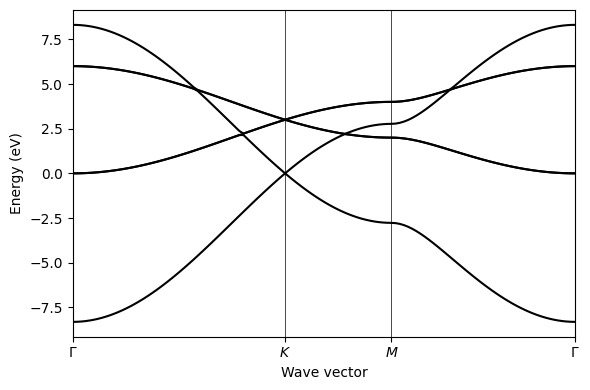

In [5]:
#!/usr/bin/env python3
"""
Graphene (2‑D) : 6‑band tight‑binding band structure
Path : Γ → K → M → Γ
"""
from __future__ import print_function
from pythtb import *            # tight‑binding library
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# lattice vectors (units of the C–C distance a ≈ 1 Å)
lat = [[1.0, 0.0],              # a1
       [0.5, np.sqrt(3.)/2]]    # a2

# atomic basis: A‑site at (1/3,1/3) and B‑site at (2/3,2/3)
# give each site the three 2p‑orbitals (pz, px, py)  → 6 orbitals
orb = [[1./3, 1./3],  # 0  A‑pz
       [1./3, 1./3],  # 1  A‑px
       [1./3, 1./3],  # 2  A‑py
       [2./3, 2./3],  # 3  B‑pz
       [2./3, 2./3],  # 4  B‑px
       [2./3, 2./3]]  # 5  B‑py

model = tb_model(2, 2, lat, orb)

# on‑site energies (eV)
#   π‑orbitals (pz) at 0 eV, σ‑orbitals (px,py) 3 eV higher
model.set_onsite([0.0, 3.0, 3.0,
                  0.0, 3.0, 3.0])

# nearest‑neighbour hoppings (eV)
t_pi, t_sigma = -2.77, -1.0
pairs = [(0, 3, t_pi),      # pz  A↔B
         (1, 4, t_sigma),   # px  A↔B
         (2, 5, t_sigma)]   # py  A↔B

# apply to the three equivalent neighbours of honeycomb lattice
for ia, ib, t in pairs:
    model.set_hop(t, ia, ib, [ 0, 0])
    model.set_hop(t, ib, ia, [ 1, 0])
    model.set_hop(t, ib, ia, [ 0, 1])

# ----------------------------------------------------------------------
# high‑symmetry line  Γ → K → M → Γ   (conventional for 2‑D graphene)
path   = [[0.0, 0.0],          # Γ
          [2./3, 1./3],        # K
          [0.5, 0.5],          # M
          [0.0, 0.0]]          # Γ
labels = (r"$\Gamma$", r"$K$", r"$M$", r"$\Gamma$")
nk = 121                       # points between each node

k_vec, k_dist, k_node = model.k_path(path, nk)
evals = model.solve_all(k_vec)     # shape (6, nk)

# ----------------------------------------------------------------------
# plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlim(k_node[0], k_node[-1])
ax.set_xticks(k_node)
ax.set_xticklabels(labels)
for kn in k_node:
    ax.axvline(x=kn, linewidth=0.5, color="k")

ax.set_xlabel("Wave vector")
ax.set_ylabel("Energy (eV)")

for n in range(model._norb):       # _norb = 6 → draw every band
    ax.plot(k_dist, evals[n], c="k")

fig.tight_layout()
plt.show()


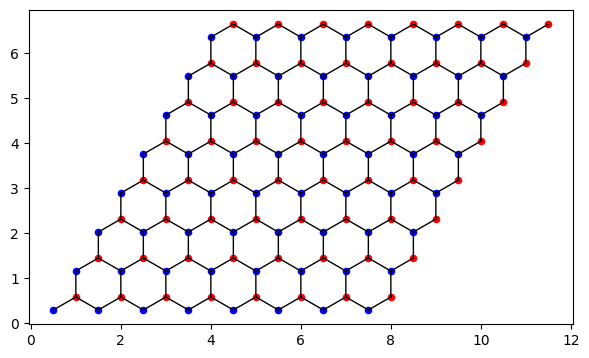

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 2‑D graphene lattice data
a1 = np.array([1.0, 0.0])
a2 = np.array([0.5, np.sqrt(3) / 2])

basis = np.array([
    [1/3, 1/3],   # A site
    [2/3, 2/3]    # B site
])

# ------------------------------------------------------------------
# build a finite patch of lattice
Nx, Ny = 8, 8                      # unit‑cells in each direction
cartesian_positions = []
sublattice = []

for i in range(Nx):
    for j in range(Ny):
        R = i * a1 + j * a2
        for s, frac in enumerate(basis):
            cartesian_positions.append(R + frac[0] * a1 + frac[1] * a2)
            sublattice.append(s)

cartesian_positions = np.array(cartesian_positions)
sublattice = np.array(sublattice)

# ------------------------------------------------------------------
# gather nearest‑neighbour bond segments
# nearest‑neighbour distance (one can compute analytically, but it is
# easier/robust to take the shortest non‑zero distance in the set).
from scipy.spatial import distance_matrix

dmat = distance_matrix(cartesian_positions, cartesian_positions)
nonzero = dmat[dmat > 1e-6]
d_nn = nonzero.min()
threshold = d_nn * 1.05           # small tolerance

segments_x = []
segments_y = []

for i, ri in enumerate(cartesian_positions):
    for j in range(i + 1, len(cartesian_positions)):
        if dmat[i, j] < threshold:
            rj = cartesian_positions[j]
            segments_x += [ri[0], rj[0], np.nan]  # NaN separators
            segments_y += [ri[1], rj[1], np.nan]

# ------------------------------------------------------------------
# plotting
fig, ax = plt.subplots(figsize=(6, 6))

# plot bonds (all in one call so they share one colour)
ax.plot(segments_x, segments_y, linewidth=1, c='k')

# plot atoms from both sublattices
A = cartesian_positions[sublattice == 0]
B = cartesian_positions[sublattice == 1]
ax.scatter(A[:, 0], A[:, 1], s=20, marker='o', c="b")
ax.scatter(B[:, 0], B[:, 1], s=20, marker='o', c="r")

ax.set_aspect('equal')
plt.tight_layout()
plt.show()


---------------------------------------
report of tight-binding model
---------------------------------------
k-space dimension           = 2
r-space dimension           = 2
number of spin components   = 1
periodic directions         = [0, 1]
number of orbitals          = 2
number of electronic states = 2
lattice vectors:
 #  0  ===>  [     1.0 ,     0.0 ]
 #  1  ===>  [     0.5 ,   0.866 ]
positions of orbitals:
 #  0  ===>  [  0.3333 ,  0.3333 ]
 #  1  ===>  [  0.6667 ,  0.6667 ]
site energies:
 #  0  ===>      -0.0
 #  1  ===>       0.0
hoppings:
<  0 | H |  1 + [  0 ,  0 ] >     ===>     -1.0 +     0.0 i
<  1 | H |  0 + [  1 ,  0 ] >     ===>     -1.0 +     0.0 i
<  1 | H |  0 + [  0 ,  1 ] >     ===>     -1.0 +     0.0 i
hopping distances:
|  pos(  0 )  - pos(  1 + [  0 ,  0 ] ) |  =    0.5774
|  pos(  1 )  - pos(  0 + [  1 ,  0 ] ) |  =    0.5774
|  pos(  1 )  - pos(  0 + [  0 ,  1 ] ) |  =    0.5774

----- k_path report begin ----------
real-space lattice vectors
 [[1.      0.  

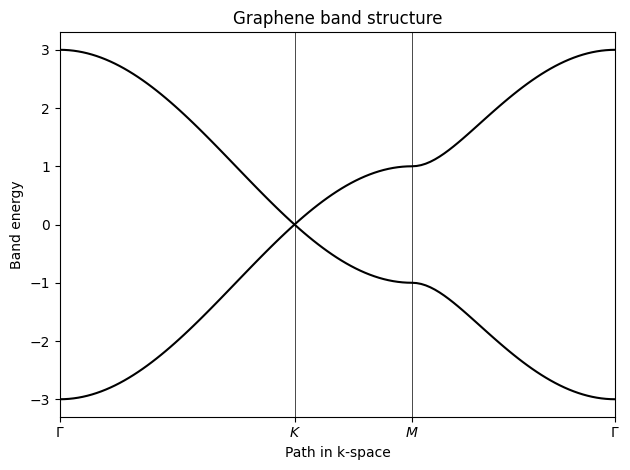

In [3]:
from __future__ import print_function
from pythtb import * # import TB model class
import numpy as np
import matplotlib.pyplot as plt

# define lattice vectors
lat=[[1.0,0.0],[0.5,np.sqrt(3.0)/2.0]]
# define coordinates of orbitals
orb=[[1./3.,1./3.],[2./3.,2./3.]]

# make two dimensional tight-binding graphene model
my_model=tb_model(2,2,lat,orb)

# set model parameters
delta=0.0
t=-1.0

# set on-site energies
my_model.set_onsite([-delta,delta])
# set hoppings (one for each connected pair of orbitals)
# (amplitude, i, j, [lattice vector to cell containing j])
my_model.set_hop(t, 0, 1, [ 0, 0])
my_model.set_hop(t, 1, 0, [ 1, 0])
my_model.set_hop(t, 1, 0, [ 0, 1])

# print tight-binding model
my_model.display()

# generate list of k-points following a segmented path in the BZ
# list of nodes (high-symmetry points) that will be connected
path=[[0.,0.],[2./3.,1./3.],[.5,.5],[0.,0.]]
# labels of the nodes
label=(r'$\Gamma $',r'$K$', r'$M$', r'$\Gamma $')
# total number of interpolated k-points along the path
nk=121

# call function k_path to construct the actual path
(k_vec,k_dist,k_node)=my_model.k_path(path,nk)
# inputs:
#   path, nk: see above
#   my_model: the pythtb model
# outputs:
#   k_vec: list of interpolated k-points
#   k_dist: horizontal axis position of each k-point in the list
#   k_node: horizontal axis position of each original node

print('---------------------------------------')
print('starting calculation')
print('---------------------------------------')
print('Calculating bands...')

# obtain eigenvalues to be plotted
evals=my_model.solve_all(k_vec)

# figure for bandstructure

fig, ax = plt.subplots()
# specify horizontal axis details
# set range of horizontal axis
ax.set_xlim(k_node[0],k_node[-1])
# put tickmarks and labels at node positions
ax.set_xticks(k_node)
ax.set_xticklabels(label)
# add vertical lines at node positions
for n in range(len(k_node)):
  ax.axvline(x=k_node[n],linewidth=0.5, color='k')
# put title
ax.set_title("Graphene band structure")
ax.set_xlabel("Path in k-space")
ax.set_ylabel("Band energy")

# plot first and second band
ax.plot(k_dist,evals[0], c='k')
ax.plot(k_dist,evals[1], c='k')

# make an PDF figure of a plot
fig.tight_layout()